<a href="https://colab.research.google.com/github/jweir136/Using-Moving-Averages-1/blob/master/Using_MV_As_Feature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Moving Average of a Feature

The following notebook is an example of how to use the moving average as a feature in a time series problem.  This example uses the historic stock price of $XOM.

***Be sure to read the comments in the code.***

In [0]:
# Start by importing the required packages.
# also be sure to set matplotlib to inline so that it can be viewed in the notebook.

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf

%matplotlib inline

## Preparing the Data

These are the steps required before the features can be created and modeled.

In [0]:
# Add the data from the csv file. Be sure to parse the dates.

data = pd.read_csv("XOM.csv", parse_dates=['date'])

In [0]:
# Set the index of the DF to the dates. This helps for graphing, as the x-axis labels will be the dates.

data.set_index("date", drop=True, inplace=True)

In [0]:
"""
  Now we only want to use the close values for this tutorial. This is called a univariate time series problem.
  To do this, we are going to set the DF equal to the only column in the DF that we want to use, the closing prices.
"""

data = data['close']

In [0]:
# Now let's look at the new DF.

data.head(10)

date
2014-01-13    82.0299
2014-01-14    82.5043
2014-01-15    82.2213
2014-01-16    82.3545
2014-01-17    82.5376
2014-01-21    81.9883
2014-01-22    81.4722
2014-01-23    80.7147
2014-01-24    78.9501
2014-01-27    79.0084
Name: close, dtype: float64

In [0]:
"""
  Now looking at the data, we see a problem here.
  The frequency that the data is sampled isn't very constant.
  This is normal for stocks considering that the market isn't open every day.
  But this can cause problems for our model.
  To solve this, we are going to instead use the mean of every month as our data.
"""

data = data.resample("MS").mean()

In [0]:
"""
  Now that we have our resampled data, we want to try to decide if this time series problem can even be solved this way.
  This is called autocorrelation. If there is a high autocorrelation, then that means that this problem is suitable for time series.
  To find the autocorrelation we can use `pd.autocorr()`, or if we want to graph it we can use the statsmodels `plot_acf` function.
"""

In [0]:
data = data - data.shift(1)

In [0]:
features = data.copy()
outputs = data.copy()

In [0]:
features = features.shift(1)

In [0]:
outputs = outputs.shift(1)

In [0]:
outputs = outputs.rolling(3).mean()

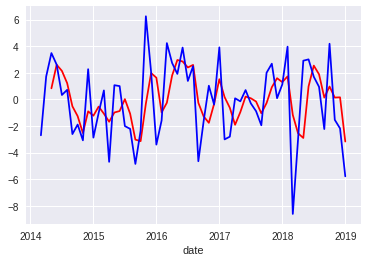

In [0]:
outputs.plot(color='red')
features.plot(color='blue')

In [0]:
trainX = features[:round(len(features) * .75)]
testX = features[round(len(features) * .75):]
trainY = outputs[:round(len(outputs) * .75)]
testY = outputs[round(len(outputs) * .75):]

In [0]:
trainX.shape, testX.shape, trainY.shape, testY.shape

((46,), (15,), (46,), (15,))

In [0]:
trainX.fillna(method='backfill', inplace=True)
trainY.fillna(method='backfill', inplace=True)
testX.fillna(method='backfill', inplace=True)
testY.fillna(method='backfill', inplace=True)

In [0]:
lr = RandomForestRegressor().fit(trainX.values.reshape(-1, 1), trainY.values.reshape(-1, 1))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [0]:
np.sqrt(mean_squared_error(testY.values.reshape(-1, 1), lr.predict(testX.values.reshape(-1, 1))))

2.116938295518003

In [0]:
preds = lr.predict(testX.values.reshape(-1, 1))

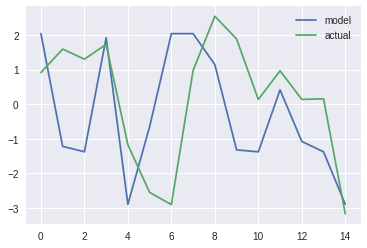

In [0]:
plt.plot([a for a in range(len(preds))], preds, label='model')
plt.plot([a for a in range(len(testX))], testY, label='actual')
plt.legend()